<a href="https://colab.research.google.com/github/glangan/energyDL/blob/main/Time_Series_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series analysis of electricity consumption using Deep Learning

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_palette("muted")

## Data Preprocessing

In [4]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/glangan/energyDL/main/energy_consumption_levels.csv')
df.head()

,3_levels,5_levels,7_levels,consumption,temperature,hour_of_day,day_of_week,day_of_month,month_of_year
0,1,1,1,0.255,-6.0,1,5,1,1
1,1,1,1,0.264,-6.9,2,5,1,1
2,1,1,1,0.253,-7.1,3,5,1,1
3,1,1,1,0.250,-7.2,4,5,1,1
4,1,1,1,0.234,-7.5,5,5,1,1


In [5]:
# Convert into time series
df['date'] = pd.to_datetime(dict(year = 2016,
                                   month = df.month_of_year,
                                   day = df.day_of_month,
                                   hour = df.hour_of_day))
df.set_index(df.date, inplace = True)
df = df.drop(['3_levels', '5_levels', '7_levels', 'hour_of_day',
                  'day_of_week', 'day_of_month', 'month_of_year', 'date'],
                 axis = 1)
df.head()

,consumption,temperature
date,,
2016-01-01 01:00:00,0.255,-6.0
2016-01-01 02:00:00,0.264,-6.9
2016-01-01 03:00:00,0.253,-7.1
2016-01-01 04:00:00,0.250,-7.2
2016-01-01 05:00:00,0.234,-7.5


## Visualisations

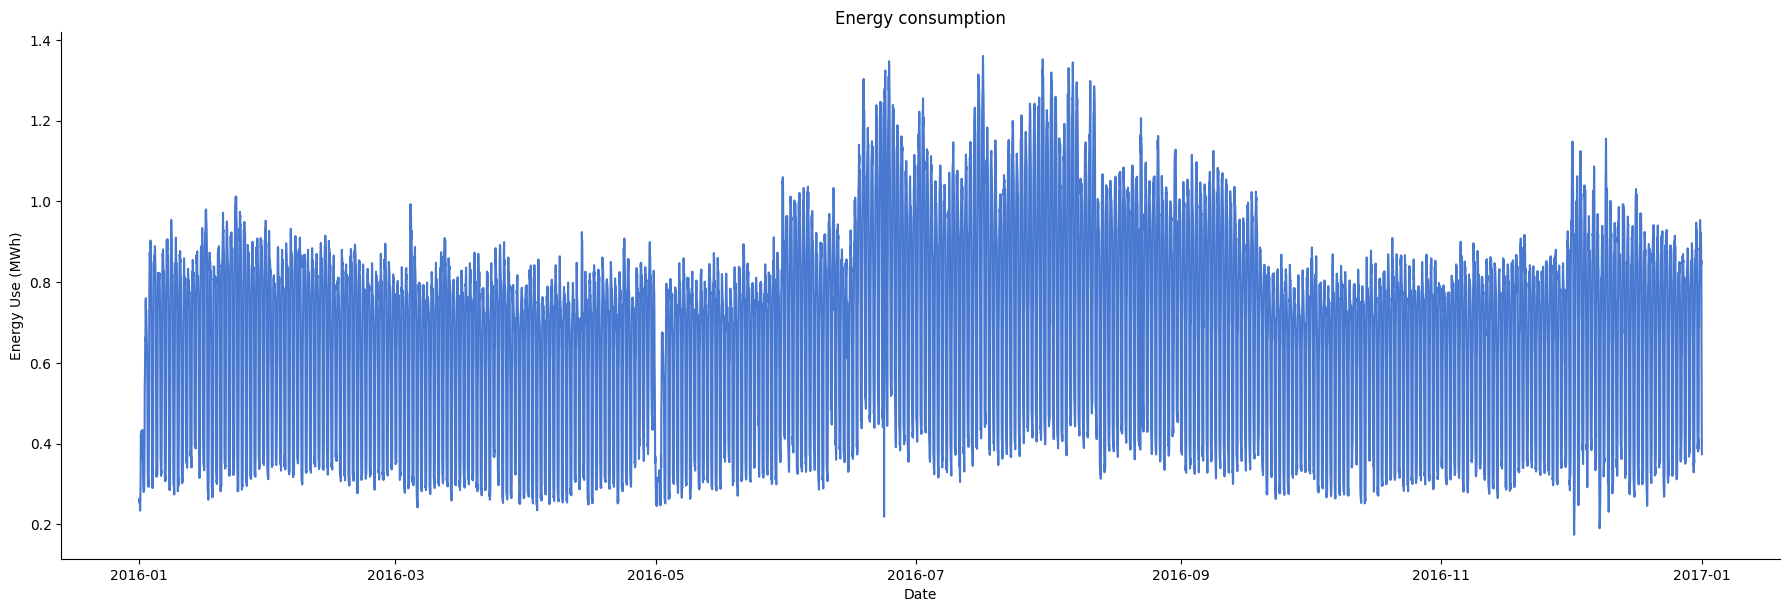

In [ ]:
# Plot consumption level
sns.relplot(x = df.index, y = 'consumption', data = df,
            kind = 'line', height = 6, aspect = 3).set(
                title="Energy consumption",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")

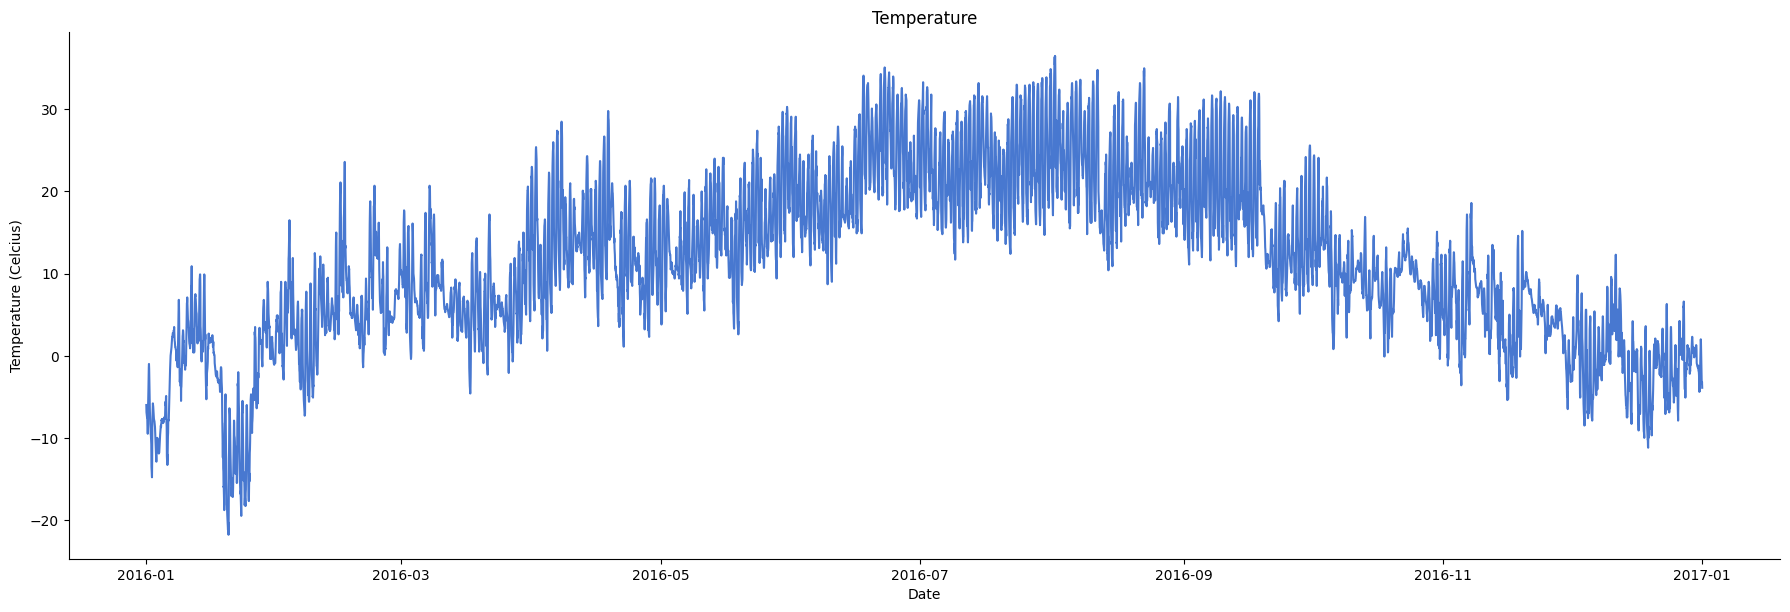

In [ ]:
# Plot temperature
sns.relplot(x = df.index.values, y = 'temperature', data = df,
            kind = 'line', height = 6, aspect = 3).set(
                title="Temperature",
                xlabel = "Date",
                ylabel = "Temperature (Celcius)")

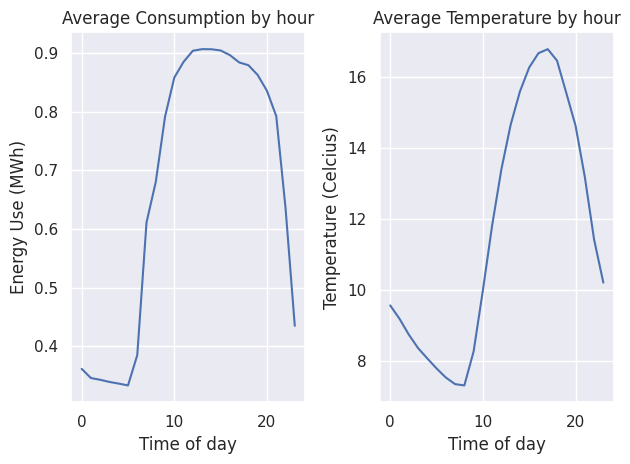

In [ ]:
# Average consumption by hour
data_hour = df.groupby(df.index.hour).mean()

sns.set()
fig, axes = plt.subplots(1, 2)

sns.lineplot(x = data_hour.index, y = 'consumption',
             data=data_hour, ax=axes[0]).set(
    title="Average Consumption by hour",
    xlabel="Time of day",
    ylabel="Energy Use (MWh)")

sns.lineplot(x = data_hour.index, y = 'temperature',
             data = data_hour, ax=axes[1]).set(
    title="Average Temperature by hour",
    xlabel="Time of day",
    ylabel="Temperature (Celcius)")

fig.tight_layout()

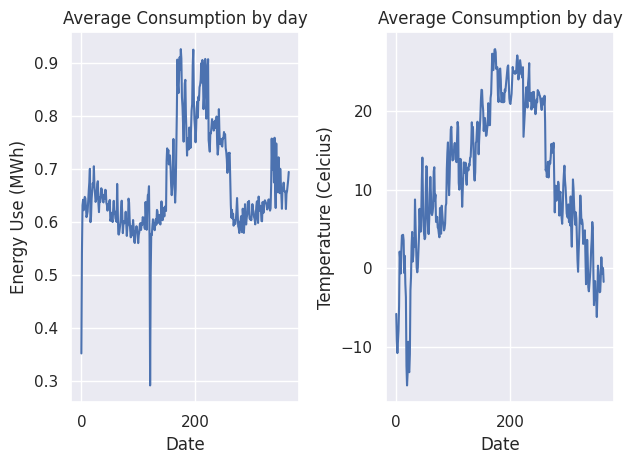

In [ ]:
# Average consumption by day
data_day = df.groupby(by=[df.index.month, df.index.day]).mean()
data_day.index.names = ['date', 'month']
data_day.reset_index(level = ['month', 'date'], inplace = True)

sns.set()
fig, axes = plt.subplots(1, 2)

sns.lineplot(x = data_day.index, y = 'consumption',
             data=data_day, ax=axes[0]).set(
    title="Average Consumption by day",
    xlabel="Date",
    ylabel="Energy Use (MWh)")

sns.lineplot(x = data_day.index, y = 'temperature',
             data = data_day, ax=axes[1]).set(
    title="Average Consumption by day",
    xlabel="Date",
    ylabel="Temperature (Celcius)")

fig.tight_layout()

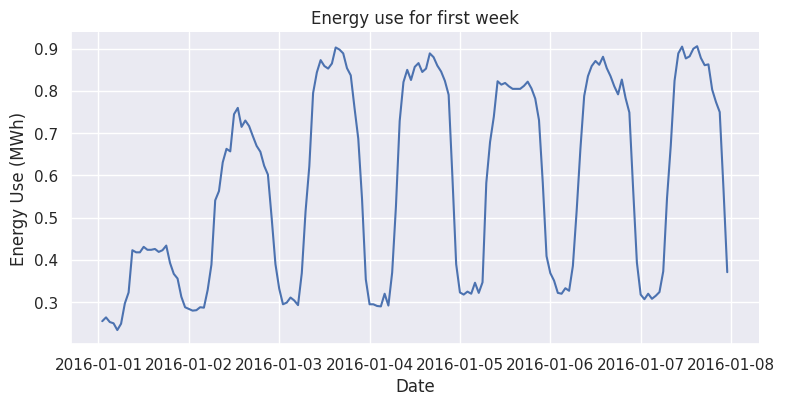

In [ ]:
# plot first week of data
week = df.iloc[:167, 0]

sns.relplot(x = week.index, y=week.values, data = week,
            kind = 'line', height = 4, aspect = 2).set(
                title="Energy use for first week",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")

## ARIMA

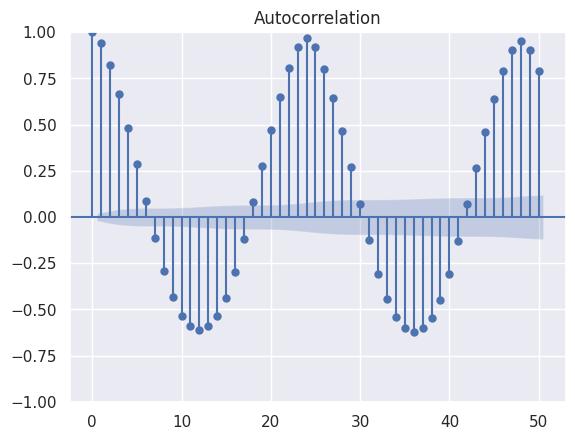

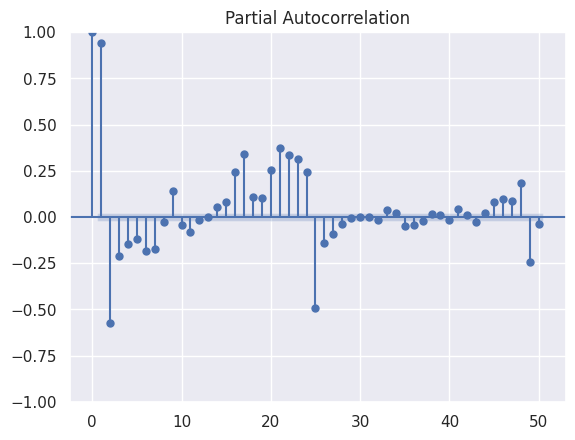

In [ ]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

cons = df['consumption']
plt_acf = plot_acf(cons, lags = 50)
plt_pacf = plot_pacf(cons, lags = 50)

In [ ]:
# Train test split
# Test data - last 2 months

cons_train = cons[:7320]
cons_test = cons[7320:]

In [ ]:
# Grid search
auto_arima(cons_train, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-17756.576, Time=20.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14774.523, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17143.679, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16458.691, Time=4.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14776.522, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17213.317, Time=7.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17210.101, Time=2.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-17534.990, Time=22.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-17220.202, Time=27.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17207.026, Time=8.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-17214.553, Time=33.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17208.209, Time=15.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-17512.633, Time=40.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-18006.115, Time=6.10 sec

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Developing ARIMA model
from statsmodels.tsa.arima.model import ARIMA

cons_train.index = pd.DatetimeIndex(cons_train.index).to_period('H')
cons_test.index = pd.DatetimeIndex(cons_test.index).to_period('H')

arima_model = ARIMA(cons_train, order = (2,1,2))
pred = arima_model.fit()

pred.summary()

predictions = pred.predict(start = len(cons_train),
                           end = len(cons_train)+len(cons_test) - 1,
                           typ = 'levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'ARIMA Predictions (2 Months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

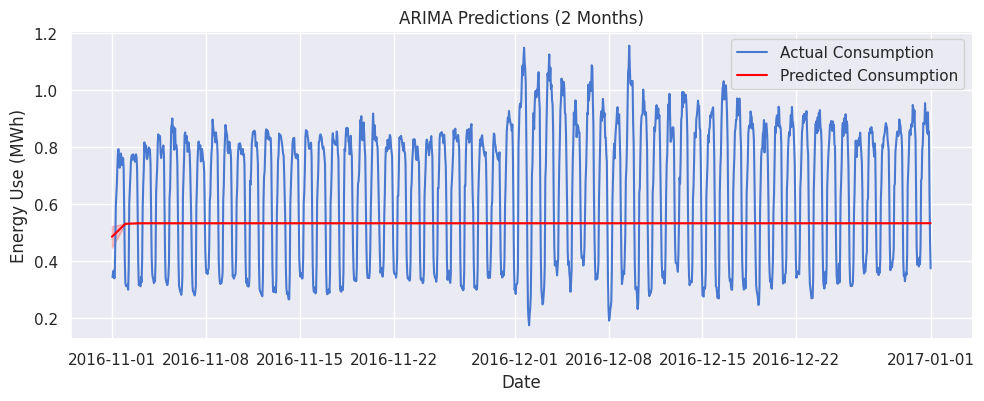

In [ ]:
cons_test = cons_test.to_timestamp()
sns.relplot(x = cons_test.index, y=cons_test.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="ARIMA Predictions (2 Months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions, color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
import math
from sklearn.metrics import mean_squared_error

rmse_ar_2m = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_ar_2m

0.26539232465274926

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'ARIMA Predictions (1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

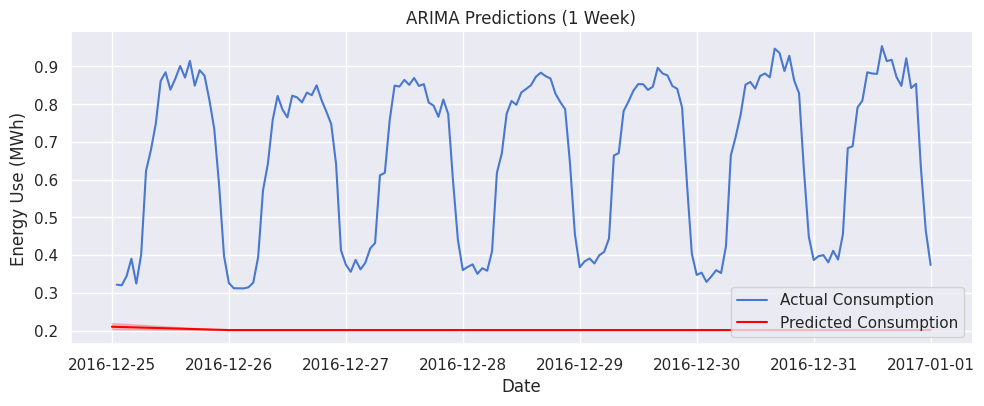

In [ ]:
# Test data - last week

cons_train = cons[:8616]
cons_test = cons[8616:]

from statsmodels.tsa.arima.model import ARIMA

cons_train.index = pd.DatetimeIndex(cons_train.index).to_period('H')
cons_test.index = pd.DatetimeIndex(cons_test.index).to_period('H')

arima_model = ARIMA(cons_train, order = (2,1,2))
pred = arima_model.fit()

pred.summary()

predictions = pred.predict(start = len(cons_train),
                           end = len(cons_train)+len(cons_test) - 1,
                           typ = 'levels')

cons_test = cons_test.to_timestamp()
sns.relplot(x = cons_test.index, y=cons_test.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="ARIMA Predictions (1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions, color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
rmse_ar_1w = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_ar_1w

0.5085025170434112

## SARIMA

In [ ]:
# SARIMA Parameters using grid search
auto_arima(cons_train,
           m = 24,
           start_p = 1,
           start_q = 1,
           max_p = 2,
           max_q = 2,
           start_P = 0,
           start_Q = 0,
           max_P = 1,
           max_Q = 1,
           trace = True)

Performing stepwise search to minimize aic


KeyboardInterrupt: ignored

In [ ]:
# Developing SARIMAX model
cons_train = cons[:7320]
cons_test = cons[7320:]

model_sarimax = SARIMAX(cons_train,
                order = (0, 1, 2), seasonal_order=(1, 0, 1, 24))

predictor = model_sarimax.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'SARIMA Predictions (2 Months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

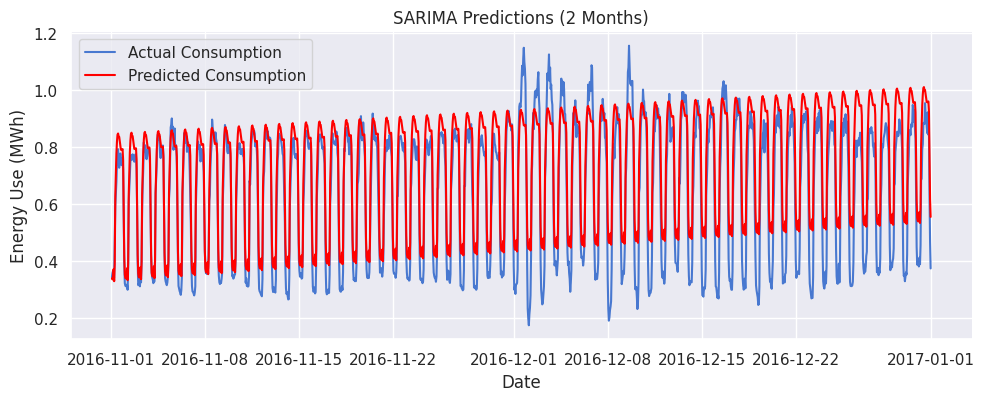

In [ ]:
# Predictions and model evaluation
predictions = predictor.predict(start = len(cons_train),
                                end = len(cons_train) + len(cons_test) - 1)


sns.relplot(x = cons_test.index, y=cons_test.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="SARIMA Predictions (2 Months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions, color = 'red', label = 'Predicted Consumption')

In [ ]:
rmse_sar_2m = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_sar_2m

0.10718666138925319

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'SARIMA Predictions (1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

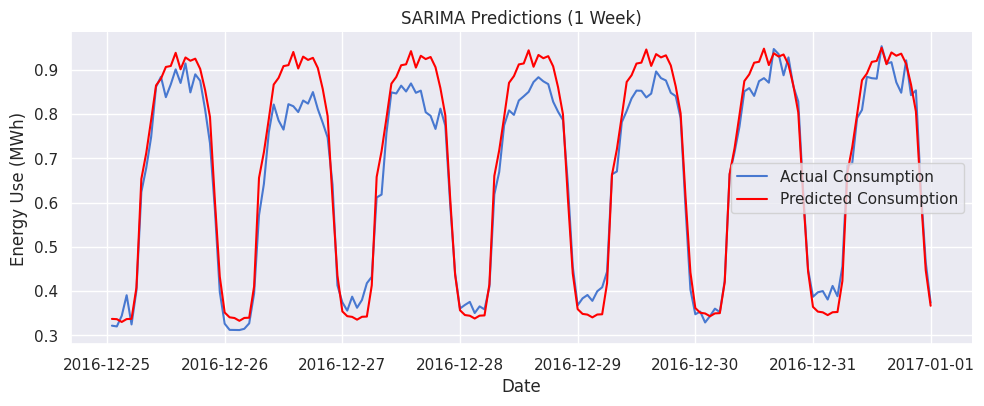

In [ ]:
# Test - Last week
cons_train = cons[:8616]
cons_test = cons[8616:]

model_sarimax = SARIMAX(cons_train,
                order = (0, 1, 2), seasonal_order=(1, 0, 1, 24))

predictor = model_sarimax.fit()

predictions = predictor.predict(start = len(cons_train),
                                end = len(cons_train) + len(cons_test) - 1)


sns.relplot(x = cons_test.index, y=cons_test.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="SARIMA Predictions (1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions, color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
import math
from sklearn.metrics import mean_squared_error

rmse_sar_1w = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_sar_1w

0.05073721677323488

# Univariate LSTM

In [ ]:
# Test set last two months
# Create a train and test set

train = df.iloc[:7320,0:1].values
test = df.iloc[7320:,0:1].values


from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [ ]:
# Create Lookback
X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:1])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
# Developing LSTM Model

Model_P = Sequential()

Model_P.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1],1)))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60))
Model_P.add(Dropout(0.2))

Model_P.add(Dense(units = 1))

Model_P.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model_P.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
228/228 [==============================] - 43s 117ms/step - loss: 0.0297
Epoch 2/10
228/228 [==============================] - 25s 109ms/step - loss: 0.0067
Epoch 3/10
228/228 [==============================] - 25s 110ms/step - loss: 0.0059
Epoch 4/10
228/228 [==============================] - 28s 123ms/step - loss: 0.0053
Epoch 5/10
228/228 [==============================] - 29s 126ms/step - loss: 0.0046
Epoch 6/10
228/228 [==============================] - 25s 112ms/step - loss: 0.0042
Epoch 7/10
228/228 [==============================] - 24s 106ms/step - loss: 0.0042
Epoch 8/10
228/228 [==============================] - 29s 126ms/step - loss: 0.0036
Epoch 9/10
228/228 [==============================] - 27s 118ms/step - loss: 0.0037
Epoch 10/10
228/228 [==============================] - 25s 110ms/step - loss: 0.0038


In [ ]:
# Prediction

prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,1))

for i in range(1464):
    First_Pred = Model_P.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_Pred)
    Batch_New = np.append(Batch_New[:,1:,:], [[First_Pred]], axis = 1)

prediction_test = np.array(prediction_test)

predictions = sc.inverse_transform(prediction_test)

<Axes: title={'center': 'LSTM Predictions (Univariate)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

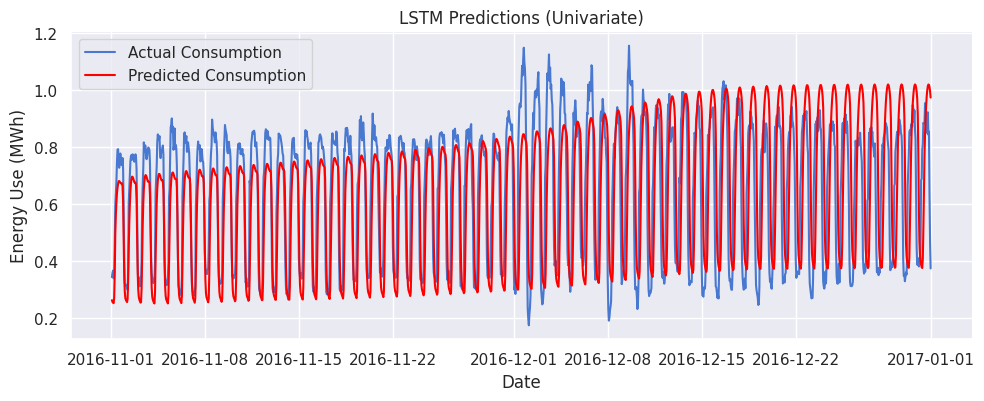

In [ ]:
pred_data = pd.DataFrame(test, columns =['value'])
pred_data.set_index(df.iloc[7320:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[7320:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Univariate)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
rmse_lstm_2m = math.sqrt(mean_squared_error(test, predictions))
rmse_lstm_2m

0.2001535154277476

In [ ]:
# Test Set: Last week
train = df.iloc[:8616,0:1].values
test = df.iloc[8616:,0:1].values


from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:1])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

Model_P = Sequential()

Model_P.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1],1)))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60))
Model_P.add(Dropout(0.2))

Model_P.add(Dense(units = 1))

Model_P.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model_P.fit(X_train, y_train, epochs = 30, batch_size = 32)

prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,1))

for i in range(168):

    First_Pred = Model_P.predict(Batch_New, verbose = 0)[0]

    prediction_test.append(First_Pred)

    Batch_New = np.append(Batch_New[:,1:,:], [[First_Pred]], axis = 1)


prediction_test = np.array(prediction_test)

predictions = sc.inverse_transform(prediction_test)

Epoch 1/30
269/269 [==============================] - 23s 57ms/step - loss: 0.0269
Epoch 2/30
269/269 [==============================] - 15s 56ms/step - loss: 0.0062
Epoch 3/30
269/269 [==============================] - 16s 59ms/step - loss: 0.0052
Epoch 4/30
269/269 [==============================] - 15s 57ms/step - loss: 0.0045
Epoch 5/30
269/269 [==============================] - 15s 56ms/step - loss: 0.0042
Epoch 6/30
269/269 [==============================] - 16s 58ms/step - loss: 0.0038
Epoch 7/30
269/269 [==============================] - 15s 57ms/step - loss: 0.0036
Epoch 8/30
269/269 [==============================] - 15s 57ms/step - loss: 0.0032
Epoch 9/30
269/269 [==============================] - 15s 57ms/step - loss: 0.0032
Epoch 10/30
269/269 [==============================] - 17s 65ms/step - loss: 0.0032
Epoch 11/30
269/269 [==============================] - 15s 56ms/step - loss: 0.0030
Epoch 12/30
269/269 [==============================] - 15s 54ms/step - loss: 0.0029
E

<Axes: title={'center': 'LSTM Predictions (Univariate, 1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

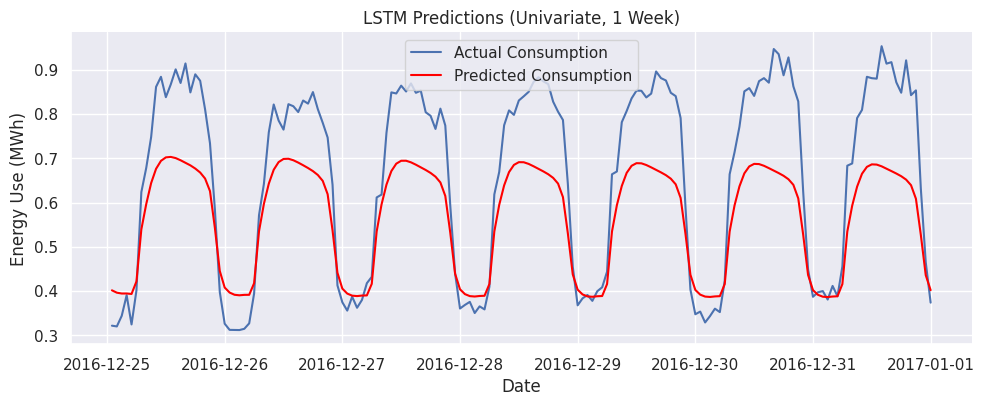

In [ ]:
pred_data = pd.DataFrame(test, columns =['value'])
pred_data.set_index(df.iloc[8616:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[8616:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Univariate, 1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
rmse_lstm_1w = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_lstm_1w

0.13765030571919465

## Multivariate LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
# Create Training and test dataset

training_set = df.iloc[:8616, 0:2].values
test_set = df.iloc[8616:, 0:2].values

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 1:2]

In [ ]:
# Create lookback (24H)

X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:2])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 2))

Epoch 1/30
269/269 [==============================] - 67s 205ms/step - loss: 0.0188
Epoch 2/30
269/269 [==============================] - 38s 140ms/step - loss: 0.0050
Epoch 3/30
269/269 [==============================] - 42s 155ms/step - loss: 0.0045
Epoch 4/30
269/269 [==============================] - 40s 147ms/step - loss: 0.0038
Epoch 5/30
269/269 [==============================] - 38s 143ms/step - loss: 0.0034
Epoch 6/30
269/269 [==============================] - 39s 144ms/step - loss: 0.0032
Epoch 7/30
269/269 [==============================] - 40s 147ms/step - loss: 0.0031
Epoch 8/30
269/269 [==============================] - 38s 143ms/step - loss: 0.0028
Epoch 9/30
269/269 [==============================] - 38s 142ms/step - loss: 0.0030
Epoch 10/30
269/269 [==============================] - 42s 156ms/step - loss: 0.0027
Epoch 11/30
269/269 [==============================] - 38s 141ms/step - loss: 0.0026
Epoch 12/30
269/269 [==============================] - 39s 145ms/step - lo

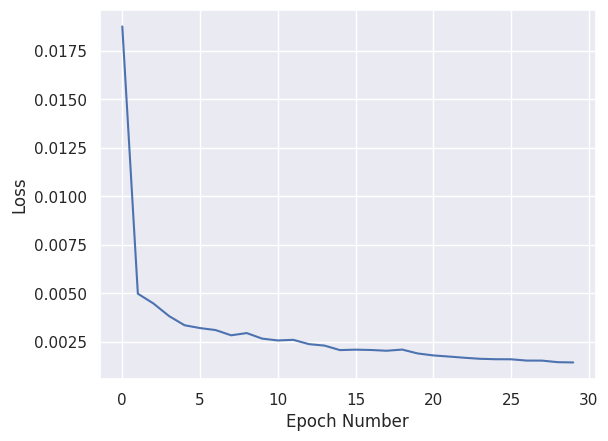

In [ ]:
# Create LSTM Model

Model = Sequential()

Model.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 2)))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120))
Model.add(Dropout(0.2))

Model.add(Dense(units = 1))

Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model.fit(X_train,y_train, epochs = 30, batch_size = 32)

plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

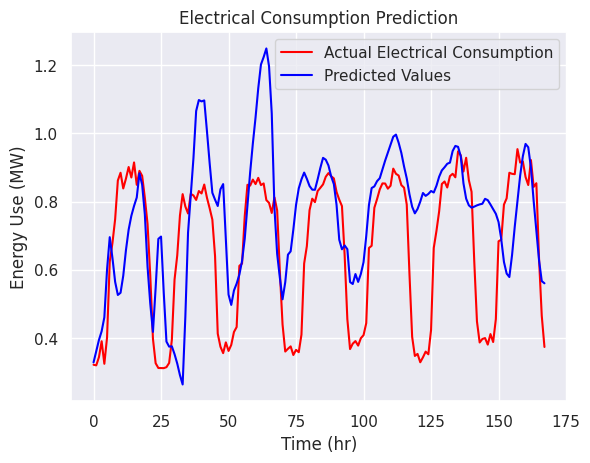

In [ ]:
# Make predictions
prediction_test = []
Batch_one = training_set_scaled[-24:]
Batch_New = Batch_one.reshape((1,24,2))

for i in range(168):
    First_pred = Model.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_pred)
    New_var = test_set_scaled[i,:]
    New_var = New_var.reshape(1,1)
    New_test = np.insert(New_var, 1, [First_pred], axis =1)
    New_test = New_test.reshape(1,1,2)
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)

prediction_test = np.array(prediction_test)

SI = MinMaxScaler(feature_range = (0,1))
y_Scale = training_set[:,0:1]
SI.fit_transform(y_Scale)

predictions = SI.inverse_transform(prediction_test)

real_values = test_set[:, 0]

plt.plot(real_values, color = 'red', label = 'Actual Electrical Consumption')
plt.plot(predictions, color = 'blue', label = 'Predicted Values')
plt.title('Electrical Consumption Prediction')
plt.xlabel('Time (hr)')
plt.ylabel('Energy Use (MW)')
plt.legend()
plt.show()

<Axes: title={'center': 'LSTM Predictions (Multivariate, 1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

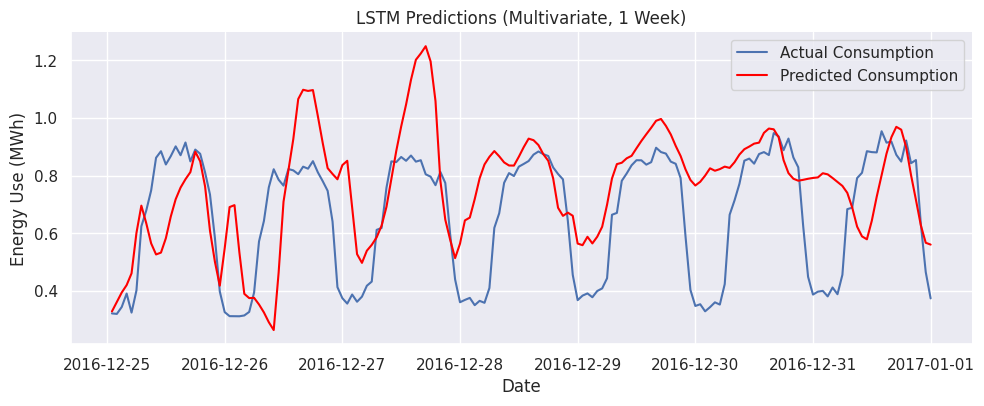

In [ ]:
pred_data = pd.DataFrame(real_values, columns =['value'])
pred_data.set_index(df.iloc[8616:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[8616:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Multivariate, 1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [ ]:
# RMSE
rmse_mlstm_1w = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_mlstm_1w

0.22579066329982467

In [ ]:
# Create Training and test dataset

training_set = df.iloc[:7320, 0:2].values
test_set = df.iloc[7320:, 0:2].values

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 1:2]

In [ ]:
# Create lookback (24H)
X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:2])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 2))

Epoch 1/30
228/228 [==============================] - 91s 373ms/step - loss: 0.0217
Epoch 2/30
228/228 [==============================] - 77s 340ms/step - loss: 0.0066
Epoch 3/30
228/228 [==============================] - 75s 329ms/step - loss: 0.0054
Epoch 4/30
228/228 [==============================] - 87s 383ms/step - loss: 0.0048
Epoch 5/30
228/228 [==============================] - 84s 369ms/step - loss: 0.0046
Epoch 6/30
228/228 [==============================] - 78s 342ms/step - loss: 0.0039
Epoch 7/30
228/228 [==============================] - 80s 352ms/step - loss: 0.0036
Epoch 8/30
228/228 [==============================] - 75s 331ms/step - loss: 0.0033
Epoch 9/30
228/228 [==============================] - 86s 377ms/step - loss: 0.0032
Epoch 10/30
228/228 [==============================] - 80s 350ms/step - loss: 0.0030
Epoch 11/30
228/228 [==============================] - 76s 334ms/step - loss: 0.0029
Epoch 12/30
228/228 [==============================] - 75s 331ms/step - lo

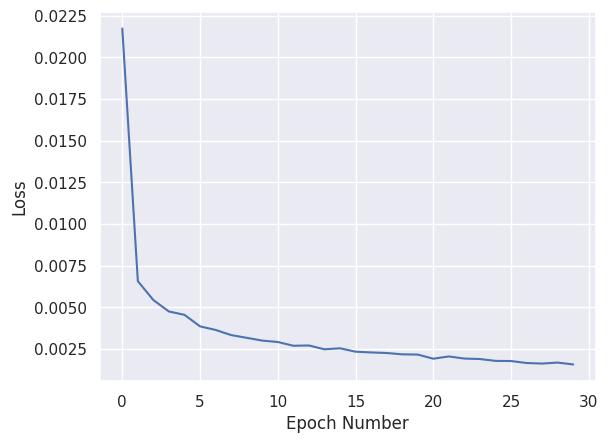

In [ ]:
# Create LSTM Model

Model = Sequential()

Model.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 2)))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120))
Model.add(Dropout(0.2))

Model.add(Dense(units = 1))

Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model.fit(X_train,y_train, epochs = 30, batch_size = 32)

plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Make predictions
prediction_test = []
Batch_one = training_set_scaled[-24:]
Batch_New = Batch_one.reshape((1,24,2))

for i in range(1464):
    First_pred = Model.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_pred)
    New_var = test_set_scaled[i,:]
    New_var = New_var.reshape(1,1)
    New_test = np.insert(New_var, 1, [First_pred], axis =1)
    New_test = New_test.reshape(1,1,2)
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)

prediction_test = np.array(prediction_test)

SI = MinMaxScaler(feature_range = (0,1))
y_Scale = training_set[:,0:1]
SI.fit_transform(y_Scale)

predictions = SI.inverse_transform(prediction_test)

real_values = test_set[:, 0]

<Axes: title={'center': 'LSTM Predictions (Multivariate, 2 months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

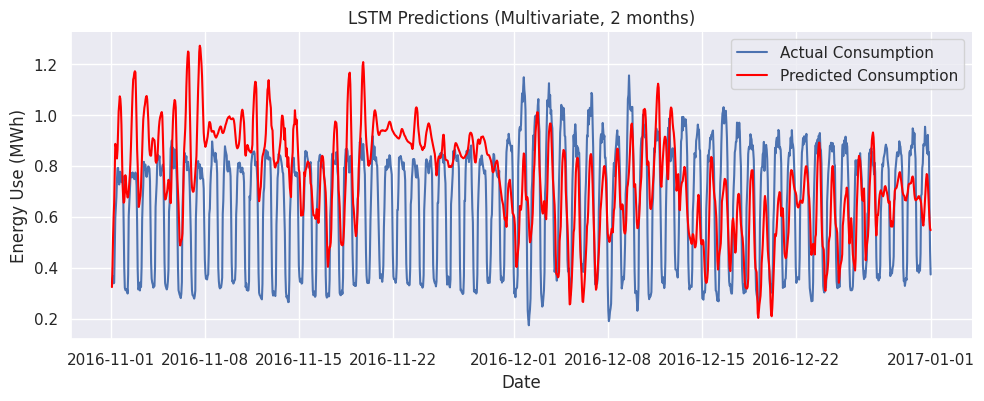

In [ ]:
pred_data = pd.DataFrame(real_values, columns =['value'])
pred_data.set_index(df.iloc[7320:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[7320:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Multivariate, 2 months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [ ]:
rmse_mlstm_2m = math.sqrt(mean_squared_error(test_set[:,0], predictions))
rmse_mlstm_2m

0.2631936676468912